# CS4305TU: Week 6 - Artificial Neural Network - Lecture 2
**7 October 2021**

- Sander van Cranenburgh ([S.vanCranenburgh@tudelft.nl]())
- Francisco Garrido-Valenzuela ([F.O.GarridoValenzuela@tudelft.nl]())

**This notebook will not be graded. You do not have to submit the notebook.**

## 1. Set up your environment

You need to set up your environment based on which platform you would like to use. In this case we offer two options:

- Google Colaboratory (Colab)
- Jupyter Lab or Notebooks (Local)

### Using Colab

Students using **Colab**, are ready to work! :)



In [1]:
# Uncomment and run this cell if you are using Google Colab (keep the exclamation mark)
#!pip install biogeme
#!git clone https://github.com/cs4305tu/exercises

### Using local environment

Students using their *local environments*, need to install all the dependencies used in this *Week 6*, to ensure compatibility, they also need to check the versions of each dependency. All dependencies are contained in the text file: **requirements.txt**. Just run the following notebook cell:

In [24]:
# Uncomment and run this cell if you are using your local environment (keep the exclamation mark)
#!pip3 install -r requirements.txt

<br><br><br>
## Exercise 3: The effect of the number of nodes and the learning rate on the model performance and training of ANNs

**Objectives:** 
* Understand the effects of number of nodes on the model performance
* Understand the the effect of the learning rate on training time and model convergence
* Apply Tensor Flow 2 to create and train more advanced ANN typologies

### i. import Python packages and modules

In [2]:
import tensorflow as tf
print("Using tensorflow ",tf.__version__)
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K
from keras.layers import Input, Dense, Activation
from keras.layers import Conv2D, Add, Reshape
from keras.models import Model
from keras.utils.np_utils import to_categorical   
import matplotlib.pyplot as plt
import numpy as np

# Import ML packaged and modules
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, log_loss

Using tensorflow  2.6.0


### ii. Load the data and create a dataframe 
Note that we use the samedata set as in Lecture 1.

In [3]:
#The data
df = pd.read_csv('week6/datasets/dcm/smartphone_choicedata2021.csv', sep='\t')

# Define the features
X = df[['COST_1','SIZE_1','STORAGE_1','CAM_1','COST_2','SIZE_2','STORAGE_2','CAM_2','COST_3','SIZE_3','STORAGE_3','CAM_3','GENDER','INC']]

# Define the output target
Y = df['CHOICE']


### iii. Split the data in a training set and a test set and rescale the input data

In [4]:
# Split the data in a training set and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33)

# Define scaler 
scaler = StandardScaler()  
scaler.fit(X_train)  

# Apply scaler to both the training and test set
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

### iv. Investigate the effect of the number of nodes on the model performance
To do so, we use the same ANN as in Exercise 2. But, we train this ANN using a different number of nodes in the hidden layers: [1,2,3,5,7,10]

(0.4, 1.0)

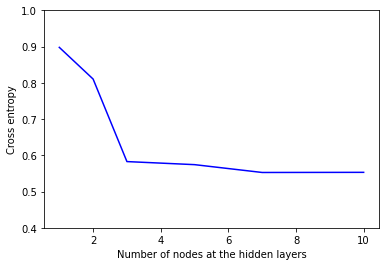

In [5]:
# Define the model for using it in the for loop
def new_ann_sk(num_nodes = 5, epoch = 400):

    # Buid the ANN
    layers = (num_nodes,num_nodes) # Here we use a network with two hidden layers, with *num_nodes* each 

    # Create the ANNs (MultiLayerPerceptron aka MLP)
    mlp = MLPClassifier(solver = 'adam', alpha = 1e-5, hidden_layer_sizes = layers, max_iter = 1000) 

    # Train the ANN. Note that sklearn does not permit anything else than batch gradient descent
    mlp.fit(X_train, Y_train)

    # Use the trained ANN to make predictions for the test data
    probs_ANN_X_test = mlp.predict_proba(X_test)

    # Compute the prediction performance, based on the cross-entropy (aka log_loss). A lower cross-entropy signals a better model.
    cross_entropy_ANN = log_loss(Y_test, probs_ANN_X_test)
    #print(f'The cross-entropy on the test data of the ANN with {num_nodes} is {cross_entropy_ANN}')
    return cross_entropy_ANN


# Train the model using a different number of nodes and collec the cross-entropy for each typology
nodes_range = [1,2,3,5,7,10]
cross_val = []
for nneurons in nodes_range:
    cross_val.append(new_ann_sk(num_nodes = nneurons, epoch = 400))

# Plot cross entropy as a function the number of nodes in the (two) hidden layers
plt.subplot(111)
plt.plot(nodes_range,cross_val, color = 'blue', label = 'test')
plt.xlabel('Number of nodes at the hidden layers')
plt.ylabel('Cross entropy')
plt.ylim(0.4, 1)


### QUESTION 1. Regarding the effect of the nodes:
- #### (a) What is the 'optimal number of nodes' for these data set?
- #### (b) Why does adding more nodes lead to a better model performance (up until some point)?
- #### (c) Why does the model performance not further improve when adding more nodes after say 10?

<font color='red'>

**ANSWER** <br>

...

### v. Rebuild the ANN in TensorFlow
Next, we rebuild the ANN of SKLearn in TensorFlow (TF). TF allows for building more advanced networks and for more custom tweaking and tuning. We need TF to be able to build the Hybrid ANNs in exercise 4.

#### a. Convert output labels to categoricals
TF requires the output labels the be categorical for classification tasks

In [6]:
Y_train_c = to_categorical(Y_train-1, num_classes = 3)
Y_test_c = to_categorical(Y_test-1, num_classes = 3)

#### b. Building the ANN structure

In TF there are various ways to build a network. Here we use Keras **Functional API**. The Keras functional API is a way to create graph neural networks that are more flexible than using a **Sequential API**. The Functional API can handle models with non-linear topology, shared layers, and even multiple inputs or outputs.

- [Functional API documentation](https://www.tensorflow.org/guide/keras/functional)
- [Sequential API documentation](https://www.tensorflow.org/guide/keras/sequential_model)

We build the layers one by one and then create the model by pulling these together

In [7]:
# Create the input layer
X = Input((X_train.shape[1]), name ='features')

# Create the hidden layers
num_nodes = 5 # Number of nodes per hidden layer
layer1 = Dense(units = num_nodes, name = "layer1", use_bias = True)(X)           
layer2 = Dense(units = num_nodes, name = "layer2", use_bias = True)(layer1)

# Create the output layer 
Y = Dense(units = Y_train_c.shape[1], activation='softmax', name = "output")(layer2) 

# Create the model by indicating the input and outputs in the graph of layers
model = Model(inputs = X, outputs = Y)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, 14)]              0         
_________________________________________________________________
layer1 (Dense)               (None, 5)                 75        
_________________________________________________________________
layer2 (Dense)               (None, 5)                 30        
_________________________________________________________________
output (Dense)               (None, 3)                 18        
Total params: 123
Trainable params: 123
Non-trainable params: 0
_________________________________________________________________


2021-09-28 20:51:50.178446: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### vi. Compile and train the model

In [8]:
# Compile the model, passing the traning configuration
model.compile(optimizer = Adam(learning_rate = 1e-2), metrics = ["accuracy"], loss = 'categorical_crossentropy')

# Early stopping stops the training once the performance on the test set no longer improves
early_stopping = EarlyStopping(patience = 3, monitor = 'val_loss')

# Train the model, while keeping track of the performance at each epoch
history = model.fit(X_train,Y_train_c, batch_size=len(X_train), epochs = 1000, verbose = 1, validation_data = (X_test, Y_test_c), callbacks = [early_stopping])

print('The cross-entropy on the test data of the tensor flow ANN is',"{:.3f}".format(history.history['loss'][-1]))

2021-09-28 20:51:50.269863: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000
1/1 [==============================] - 1s 617ms/step - loss: 1.3866 - accuracy: 0.3670 - val_loss: 1.2791 - val_accuracy: 0.3867
Epoch 2/1000
1/1 [==============================] - 0s 19ms/step - loss: 1.2803 - accuracy: 0.3882 - val_loss: 1.1842 - val_accuracy: 0.3870
Epoch 3/1000
1/1 [==============================] - 0s 19ms/step - loss: 1.1863 - accuracy: 0.3872 - val_loss: 1.1029 - val_accuracy: 0.4148
Epoch 4/1000
1/1 [==============================] - 0s 20ms/step - loss: 1.1058 - accuracy: 0.4106 - val_loss: 1.0359 - val_accuracy: 0.4718
Epoch 5/1000
1/1 [==============================] - 0s 20ms/step - loss: 1.0392 - accuracy: 0.4648 - val_loss: 0.9828 - val_accuracy: 0.5203
Epoch 6/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.9864 - accuracy: 0.5084 - val_loss: 0.9426 - val_accuracy: 0.5552
Epoch 7/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.9460 - accuracy: 0.5449 - val_loss: 0.9130 - val_accuracy: 0.5739
Epoch 8/1000

Epoch 59/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.5964 - accuracy: 0.7460 - val_loss: 0.6088 - val_accuracy: 0.7409
Epoch 60/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.5961 - accuracy: 0.7460 - val_loss: 0.6083 - val_accuracy: 0.7409
Epoch 61/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.5958 - accuracy: 0.7460 - val_loss: 0.6077 - val_accuracy: 0.7409
Epoch 62/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.5954 - accuracy: 0.7460 - val_loss: 0.6071 - val_accuracy: 0.7509
Epoch 63/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.5950 - accuracy: 0.7564 - val_loss: 0.6064 - val_accuracy: 0.7509
Epoch 64/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.5947 - accuracy: 0.7564 - val_loss: 0.6058 - val_accuracy: 0.7509
Epoch 65/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.5943 - accuracy: 0.7564 - val_loss: 0.6053 - val_accuracy: 0.7509
Epoch 

1/1 [==============================] - 0s 18ms/step - loss: 0.5869 - accuracy: 0.7564 - val_loss: 0.5955 - val_accuracy: 0.7509
Epoch 174/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.5869 - accuracy: 0.7564 - val_loss: 0.5954 - val_accuracy: 0.7509
Epoch 175/1000
1/1 [==============================] - 0s 17ms/step - loss: 0.5869 - accuracy: 0.7564 - val_loss: 0.5954 - val_accuracy: 0.7509
Epoch 176/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.5869 - accuracy: 0.7564 - val_loss: 0.5954 - val_accuracy: 0.7509
Epoch 177/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.5869 - accuracy: 0.7564 - val_loss: 0.5954 - val_accuracy: 0.7509
Epoch 178/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.5869 - accuracy: 0.7564 - val_loss: 0.5954 - val_accuracy: 0.7509
Epoch 179/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.5869 - accuracy: 0.7564 - val_loss: 0.5954 - val_accuracy: 0.7509
Epoch 180/1000

1/1 [==============================] - 0s 20ms/step - loss: 0.5865 - accuracy: 0.7564 - val_loss: 0.5946 - val_accuracy: 0.7509
Epoch 288/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.5865 - accuracy: 0.7564 - val_loss: 0.5946 - val_accuracy: 0.7509
Epoch 289/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.5865 - accuracy: 0.7564 - val_loss: 0.5946 - val_accuracy: 0.7509
Epoch 290/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.5865 - accuracy: 0.7564 - val_loss: 0.5946 - val_accuracy: 0.7509
Epoch 291/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.5865 - accuracy: 0.7564 - val_loss: 0.5946 - val_accuracy: 0.7509
Epoch 292/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.5865 - accuracy: 0.7564 - val_loss: 0.5946 - val_accuracy: 0.7509
Epoch 293/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.5865 - accuracy: 0.7564 - val_loss: 0.5946 - val_accuracy: 0.7509
Epoch 294/1000

1/1 [==============================] - 0s 19ms/step - loss: 0.5864 - accuracy: 0.7564 - val_loss: 0.5946 - val_accuracy: 0.7509
Epoch 402/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.5864 - accuracy: 0.7564 - val_loss: 0.5946 - val_accuracy: 0.7509
Epoch 403/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.5864 - accuracy: 0.7564 - val_loss: 0.5946 - val_accuracy: 0.7509
Epoch 404/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.5864 - accuracy: 0.7564 - val_loss: 0.5946 - val_accuracy: 0.7509
Epoch 405/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.5864 - accuracy: 0.7564 - val_loss: 0.5946 - val_accuracy: 0.7509
Epoch 406/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.5864 - accuracy: 0.7564 - val_loss: 0.5946 - val_accuracy: 0.7509
Epoch 407/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.5864 - accuracy: 0.7564 - val_loss: 0.5946 - val_accuracy: 0.7509
Epoch 408/1000

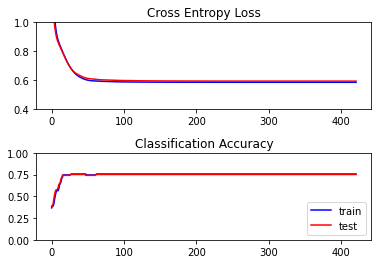

In [9]:
# plot loss as a function of epochs
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'],     color = 'blue', label = 'train')
plt.plot(history.history['val_loss'], color = 'red', label = 'test')
plt.ylim(0.4,1)

# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'],     color = 'blue', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'red', label = 'test')
plt.ylim(0, 1)
plt.legend()

# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(hspace = 0.5)

### QUESTION 2. Probably the model performance varies between the TF and SKlearn implementation of the ANN. Why do we not find the exact same results?

<font color='red'>

**ANSWER** <br>

...

### QUESTION 3. Try different values for the "learning rate" to investigate its effect on the training time and model convergence/performance. What do you see?


<font color='red'>

**ANSWER**
    
...

<br><br><br>
## **Exercise 4: Build the Hybrid RUM-MNL-ANN model**

**Objective:**  See how by combining ANNs and DCMs the best of both worlds, in terms of model peformance and interpretability can be attained

### i. Declare properties of the data set and training settings 


In [10]:
NALT = 3           # Number of alterantives in the data set.
no_X_MNL = 2       # Number of attributes with behavioural interest (-->MNL model part).  In this example we are particularly interested in the WtP for extra storage space --> Cost & Storage
no_X_ANN = 8       # Number of features without behavioural interest (-->ANN model part). In this example we are not behaviourall interested in Camera, Size, and the socio demographic variables
num_nodes = 5      # Number of nodes in hidden layer(s). Again we use 2 hidden layers with *num_nodes* nodes each
nEpoch = 500       # Number epochs for training (max). 

### ii. Create the layers of the MNL part of the hybrid model

Using the structure of TF Functional API. The MNL part is made as follow:

<img src="https://github.com/cs4305tu/week6/blob/main/MNLpart.png?raw=true" width="500"/>


In [11]:
# INPUT FOR MNL PART
X_MNL = Input((no_X_MNL, NALT,1), name = 'Features2MNL')

# COMPUTE UTILITY FOR MNL
V_MNL = Conv2D(filters = 1, kernel_size = [no_X_MNL,1], strides = (1,1), padding = 'valid', name = 'MNL_layer', use_bias = False, trainable = True)(X_MNL)

### iii. Create the layers of the ANN part of the hybrid model

Using the structure of TF Functional API. The ANN part is made as follow:

<img src="https://github.com/cs4305tu/week6/blob/main/ANNpart.png?raw=true" width="500"/>

In [12]:
# INPUT FOR ANN PART
X_ANN = Input((no_X_ANN), name ='Features2ANN')

# CREATE HIDDEN LAYER(S) OF ANN
layer1_ANN = Dense(units = num_nodes, name = "ANN_layer1", use_bias = True)(X_ANN) 
layer2_ANN = Dense(units = num_nodes, name = "ANN_layer2", use_bias = True)(layer1_ANN)

# COMPUTE UTILITY FOR ANN 
V_ANN = Dense(units = NALT, name = "V_ANN")(layer2_ANN) 

### iv. Combine the MNL and ANN parts and build the model

In [13]:
# RESHAPE TENSORS TO [1 X NALT]
V_MNL = Reshape([NALT], name = 'Flatten_Dim_MNL')(V_MNL)
V_ANN = Reshape([NALT], name = 'Flatten_Dim_ANN')(V_ANN) 

# SUM THE UTILITIES OF BOTH MODEL PARTS
V_MNL_ANN = Add(name = "Combining_Vs")([V_MNL,V_ANN])

# CREATE LOGIT (AKA SOFTMAX ) OUTPUT LAYER
logits = Activation('softmax', name = 'Probability')(V_MNL_ANN)

# BUILD THE MODEL
model = Model(inputs = [X_MNL, X_ANN], outputs = logits)

### v. Define the input and outputs

In [14]:
# Define the features and the output class
X = df[['COST_1','SIZE_1','STORAGE_1','CAM_1','COST_2','SIZE_2','STORAGE_2','CAM_2','COST_3','SIZE_3','STORAGE_3','CAM_3','GENDER','INC']]

# Define the output target
Y = df['CHOICE']
Y_cat = to_categorical(Y-1, num_classes = 3)

### vi. Create input variables for both parts of the model

In [15]:
# Create x input for MNL layer, and rescale
scale = 100 # We cannot just use the sklearn scaler here, as it is import for the interpretation later how the input data are scaled. 

x_mnl = np.array([[np.divide(X['COST_1'], scale), np.divide(X['STORAGE_1'], scale)],
                  [np.divide(X['COST_2'], scale), np.divide(X['STORAGE_2'], scale)],
                  [np.divide(X['COST_3'], scale), np.divide(X['STORAGE_3'], scale)]])
x_mnl = np.swapaxes(x_mnl, 0, 2)
x_mnl = np.expand_dims(x_mnl, 3)
print('Shape of x_mnl', x_mnl.shape)

# Create x input for ANN layer
x_ann = np.array([[X['SIZE_1'], X['CAM_1'], X['SIZE_2'], X['CAM_2'], X['SIZE_3'], X['CAM_3'], X['GENDER'], X['INC']]])
x_ann = np.squeeze(np.swapaxes(x_ann, 0, 2))

# Rescale input for the ANN part
scaler = StandardScaler()  
scaler.fit(x_ann)  
x_ann = scaler.transform(x_ann)  
print('Shape of x_ann',x_ann.shape)

Shape of x_mnl (10000, 2, 3, 1)
Shape of x_ann (10000, 8)


### vii. Split the data in a training set and a test set 

In [16]:
# Split the data into a training and test part
X_mnl_train, X_mnl_test, Y_train, Y_test = train_test_split(x_mnl, Y_cat, random_state = 1, test_size = 0.35)
X_ann_train, X_ann_test, Y_train, Y_test = train_test_split(x_ann, Y_cat, random_state = 1, test_size = 0.35)
print('Total number of obervations in the data set = ', len(x_mnl))
print('Number of obervations in the training set   = ', len(X_mnl_train))
print('Number of obervations in the test set       = ', len(X_mnl_test))

Total number of obervations in the data set =  10000
Number of obervations in the training set   =  6500
Number of obervations in the test set       =  3500


### viii. Compile the hybrid model

In [17]:
# Compile the model
model.compile(optimizer = Adam(learning_rate = 1e-2), metrics = ["accuracy"], loss = 'categorical_crossentropy')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Features2ANN (InputLayer)       [(None, 8)]          0                                            
__________________________________________________________________________________________________
ANN_layer1 (Dense)              (None, 5)            45          Features2ANN[0][0]               
__________________________________________________________________________________________________
Features2MNL (InputLayer)       [(None, 2, 3, 1)]    0                                            
__________________________________________________________________________________________________
ANN_layer2 (Dense)              (None, 5)            30          ANN_layer1[0][0]                 
____________________________________________________________________________________________

### ix. Train the hybrid model

In [18]:
# Train the model
early_stopping = EarlyStopping(patience = 4, monitor = 'val_loss')
history = model.fit([X_mnl_train, X_ann_train],Y_train, batch_size=len(X_mnl_train), epochs = nEpoch, verbose = 1, validation_data = ([X_mnl_test, X_ann_test], Y_test), callbacks = [early_stopping])

betas_layer = model.get_layer(name = 'MNL_layer')
betas = betas_layer.get_weights()
print('The cross-entropy on the test data of the tensor flow ANN is',"{:.3f}".format(history.history['loss'][-1]))

Epoch 1/500
1/1 [==============================] - 0s 433ms/step - loss: 2.2249 - accuracy: 0.1691 - val_loss: 2.1172 - val_accuracy: 0.1874
Epoch 2/500
1/1 [==============================] - 0s 20ms/step - loss: 2.1020 - accuracy: 0.1877 - val_loss: 2.0049 - val_accuracy: 0.1874
Epoch 3/500
1/1 [==============================] - 0s 20ms/step - loss: 1.9897 - accuracy: 0.1877 - val_loss: 1.9021 - val_accuracy: 0.1874
Epoch 4/500
1/1 [==============================] - 0s 20ms/step - loss: 1.8871 - accuracy: 0.1877 - val_loss: 1.8080 - val_accuracy: 0.1874
Epoch 5/500
1/1 [==============================] - 0s 20ms/step - loss: 1.7935 - accuracy: 0.1877 - val_loss: 1.7221 - val_accuracy: 0.1874
Epoch 6/500
1/1 [==============================] - 0s 21ms/step - loss: 1.7083 - accuracy: 0.1877 - val_loss: 1.6438 - val_accuracy: 0.1760
Epoch 7/500
1/1 [==============================] - 0s 23ms/step - loss: 1.6310 - accuracy: 0.1786 - val_loss: 1.5731 - val_accuracy: 0.1774
Epoch 8/500
1/1 [==

1/1 [==============================] - 0s 20ms/step - loss: 0.7077 - accuracy: 0.7428 - val_loss: 0.7243 - val_accuracy: 0.7434
Epoch 118/500
1/1 [==============================] - 0s 22ms/step - loss: 0.7064 - accuracy: 0.7428 - val_loss: 0.7230 - val_accuracy: 0.7434
Epoch 119/500
1/1 [==============================] - 0s 20ms/step - loss: 0.7051 - accuracy: 0.7434 - val_loss: 0.7217 - val_accuracy: 0.7577
Epoch 120/500
1/1 [==============================] - 0s 22ms/step - loss: 0.7039 - accuracy: 0.7565 - val_loss: 0.7205 - val_accuracy: 0.7577
Epoch 121/500
1/1 [==============================] - 0s 22ms/step - loss: 0.7026 - accuracy: 0.7565 - val_loss: 0.7192 - val_accuracy: 0.7577
Epoch 122/500
1/1 [==============================] - 0s 21ms/step - loss: 0.7014 - accuracy: 0.7565 - val_loss: 0.7180 - val_accuracy: 0.7577
Epoch 123/500
1/1 [==============================] - 0s 21ms/step - loss: 0.7002 - accuracy: 0.7565 - val_loss: 0.7168 - val_accuracy: 0.7577
Epoch 124/500
1/1 [=

Epoch 175/500
1/1 [==============================] - 0s 20ms/step - loss: 0.6582 - accuracy: 0.7582 - val_loss: 0.6739 - val_accuracy: 0.7580
Epoch 176/500
1/1 [==============================] - 0s 21ms/step - loss: 0.6577 - accuracy: 0.7582 - val_loss: 0.6734 - val_accuracy: 0.7580
Epoch 177/500
1/1 [==============================] - 0s 20ms/step - loss: 0.6573 - accuracy: 0.7582 - val_loss: 0.6730 - val_accuracy: 0.7580
Epoch 178/500
1/1 [==============================] - 0s 19ms/step - loss: 0.6568 - accuracy: 0.7582 - val_loss: 0.6725 - val_accuracy: 0.7580
Epoch 179/500
1/1 [==============================] - 0s 19ms/step - loss: 0.6564 - accuracy: 0.7582 - val_loss: 0.6720 - val_accuracy: 0.7580
Epoch 180/500
1/1 [==============================] - 0s 20ms/step - loss: 0.6559 - accuracy: 0.7582 - val_loss: 0.6715 - val_accuracy: 0.7580
Epoch 181/500
1/1 [==============================] - 0s 20ms/step - loss: 0.6555 - accuracy: 0.7582 - val_loss: 0.6711 - val_accuracy: 0.7580
Epoch 

Epoch 233/500
1/1 [==============================] - 0s 20ms/step - loss: 0.6406 - accuracy: 0.7651 - val_loss: 0.6546 - val_accuracy: 0.7586
Epoch 234/500
1/1 [==============================] - 0s 20ms/step - loss: 0.6404 - accuracy: 0.7651 - val_loss: 0.6544 - val_accuracy: 0.7586
Epoch 235/500
1/1 [==============================] - 0s 20ms/step - loss: 0.6402 - accuracy: 0.7651 - val_loss: 0.6541 - val_accuracy: 0.7586
Epoch 236/500
1/1 [==============================] - 0s 21ms/step - loss: 0.6400 - accuracy: 0.7651 - val_loss: 0.6539 - val_accuracy: 0.7586
Epoch 237/500
1/1 [==============================] - 0s 21ms/step - loss: 0.6397 - accuracy: 0.7651 - val_loss: 0.6537 - val_accuracy: 0.7586
Epoch 238/500
1/1 [==============================] - 0s 21ms/step - loss: 0.6395 - accuracy: 0.7651 - val_loss: 0.6534 - val_accuracy: 0.7586
Epoch 239/500
1/1 [==============================] - 0s 20ms/step - loss: 0.6393 - accuracy: 0.7651 - val_loss: 0.6532 - val_accuracy: 0.7586
Epoch 

Epoch 291/500
1/1 [==============================] - 0s 20ms/step - loss: 0.6305 - accuracy: 0.7651 - val_loss: 0.6435 - val_accuracy: 0.7586
Epoch 292/500
1/1 [==============================] - 0s 21ms/step - loss: 0.6303 - accuracy: 0.7651 - val_loss: 0.6433 - val_accuracy: 0.7586
Epoch 293/500
1/1 [==============================] - 0s 20ms/step - loss: 0.6302 - accuracy: 0.7651 - val_loss: 0.6432 - val_accuracy: 0.7586
Epoch 294/500
1/1 [==============================] - 0s 21ms/step - loss: 0.6301 - accuracy: 0.7651 - val_loss: 0.6430 - val_accuracy: 0.7586
Epoch 295/500
1/1 [==============================] - 0s 21ms/step - loss: 0.6299 - accuracy: 0.7651 - val_loss: 0.6429 - val_accuracy: 0.7586
Epoch 296/500
1/1 [==============================] - 0s 20ms/step - loss: 0.6298 - accuracy: 0.7651 - val_loss: 0.6427 - val_accuracy: 0.7586
Epoch 297/500
1/1 [==============================] - 0s 20ms/step - loss: 0.6296 - accuracy: 0.7651 - val_loss: 0.6426 - val_accuracy: 0.7586
Epoch 

Epoch 349/500
1/1 [==============================] - 0s 20ms/step - loss: 0.6233 - accuracy: 0.7651 - val_loss: 0.6357 - val_accuracy: 0.7586
Epoch 350/500
1/1 [==============================] - 0s 20ms/step - loss: 0.6232 - accuracy: 0.7651 - val_loss: 0.6356 - val_accuracy: 0.7586
Epoch 351/500
1/1 [==============================] - 0s 21ms/step - loss: 0.6231 - accuracy: 0.7651 - val_loss: 0.6355 - val_accuracy: 0.7586
Epoch 352/500
1/1 [==============================] - 0s 20ms/step - loss: 0.6230 - accuracy: 0.7651 - val_loss: 0.6354 - val_accuracy: 0.7586
Epoch 353/500
1/1 [==============================] - 0s 21ms/step - loss: 0.6229 - accuracy: 0.7651 - val_loss: 0.6353 - val_accuracy: 0.7586
Epoch 354/500
1/1 [==============================] - 0s 22ms/step - loss: 0.6228 - accuracy: 0.7651 - val_loss: 0.6351 - val_accuracy: 0.7586
Epoch 355/500
1/1 [==============================] - 0s 22ms/step - loss: 0.6227 - accuracy: 0.7651 - val_loss: 0.6350 - val_accuracy: 0.7586
Epoch 

Epoch 407/500
1/1 [==============================] - 0s 22ms/step - loss: 0.6182 - accuracy: 0.7651 - val_loss: 0.6301 - val_accuracy: 0.7586
Epoch 408/500
1/1 [==============================] - 0s 21ms/step - loss: 0.6181 - accuracy: 0.7651 - val_loss: 0.6301 - val_accuracy: 0.7586
Epoch 409/500
1/1 [==============================] - 0s 22ms/step - loss: 0.6180 - accuracy: 0.7651 - val_loss: 0.6300 - val_accuracy: 0.7586
Epoch 410/500
1/1 [==============================] - 0s 21ms/step - loss: 0.6180 - accuracy: 0.7651 - val_loss: 0.6299 - val_accuracy: 0.7586
Epoch 411/500
1/1 [==============================] - 0s 21ms/step - loss: 0.6179 - accuracy: 0.7651 - val_loss: 0.6298 - val_accuracy: 0.7586
Epoch 412/500
1/1 [==============================] - 0s 21ms/step - loss: 0.6178 - accuracy: 0.7651 - val_loss: 0.6297 - val_accuracy: 0.7586
Epoch 413/500
1/1 [==============================] - 0s 22ms/step - loss: 0.6177 - accuracy: 0.7651 - val_loss: 0.6297 - val_accuracy: 0.7586
Epoch 

Epoch 465/500
1/1 [==============================] - 0s 20ms/step - loss: 0.6145 - accuracy: 0.7651 - val_loss: 0.6262 - val_accuracy: 0.7586
Epoch 466/500
1/1 [==============================] - 0s 21ms/step - loss: 0.6145 - accuracy: 0.7651 - val_loss: 0.6261 - val_accuracy: 0.7586
Epoch 467/500
1/1 [==============================] - 0s 20ms/step - loss: 0.6144 - accuracy: 0.7651 - val_loss: 0.6261 - val_accuracy: 0.7586
Epoch 468/500
1/1 [==============================] - 0s 21ms/step - loss: 0.6144 - accuracy: 0.7651 - val_loss: 0.6260 - val_accuracy: 0.7586
Epoch 469/500
1/1 [==============================] - 0s 20ms/step - loss: 0.6143 - accuracy: 0.7651 - val_loss: 0.6259 - val_accuracy: 0.7586
Epoch 470/500
1/1 [==============================] - 0s 20ms/step - loss: 0.6143 - accuracy: 0.7651 - val_loss: 0.6259 - val_accuracy: 0.7586
Epoch 471/500
1/1 [==============================] - 0s 20ms/step - loss: 0.6142 - accuracy: 0.7651 - val_loss: 0.6258 - val_accuracy: 0.7586
Epoch 

#### Plot training progress

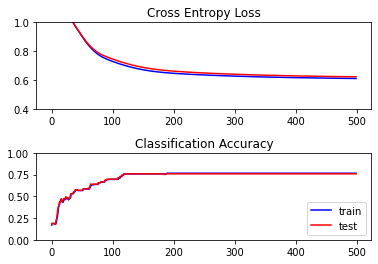

In [19]:
# plot loss as a function of epochs
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'],     color = 'blue', label = 'train')
plt.plot(history.history['val_loss'], color = 'red', label = 'test')
plt.ylim(0.4,1)

# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'],     color = 'blue', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'red', label = 'test')
plt.ylim(0, 1)
plt.legend()

# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(hspace = 0.5)

### x. Obtain behavioural insights into the Willingness-to-Pay for storage space:
- (1) Compute WtP for extra storage space from MNL part of the model
- (2) Derive insights into the importance of extra storage 

### (1) Compute WtP for extra storage from MNL part of the model

In [25]:
# Show the trained taste parameters, from the MNL part
beta_COST = np.squeeze((betas[0][0]))
beta_STORAGE = np.squeeze((betas[0][1]))
print('Beta_COST    = ', "{:.3f}".format(beta_COST )) 
print('Beta_STORAGE = ', "{:.3f}".format(beta_STORAGE ))

# Compute the Willingness to Pay for a Gb extra storage space
WtP_storage = -beta_STORAGE/beta_COST
print('WtP storage  = €', "{:.2f}".format(WtP_storage),' per extra Gigabite')
print()

# For comparison convert the loss to log-likelihood and rho^2
hist_loss_train = history.history.get('loss')
LL_final_train = -np.array(hist_loss_train[len(hist_loss_train)-1]) *len(Y_train)
print('Cross-entropy training data at final epoch  = ', "{:.3f}".format(hist_loss_train[len(hist_loss_train)-1]))
print('Log-likelihood training data at final epoch = ', "{:.1f}".format(LL_final_train))
print('rho square training data at final epoch     = ', "{:.2f}".format(1 - LL_final_train / -(len(Y_train)*np.log(3))))
print()

hist_loss_test = history.history.get('val_loss')
LL_final_test = -np.array(hist_loss_test[len(hist_loss_test)-1]) *len(Y_test)
print('Cross-entropy test data at final epoch     = ', "{:.3f}".format(hist_loss_test[len(hist_loss_test)-1]))
print('Log-likelihood test data at final epoch    = ', "{:.1f}".format(LL_final_test))
print('rho square test data at final epoch        = ', "{:.2f}".format(1 - LL_final_test / -(len(Y_test)*np.log(3))))


Beta_COST    =  -1.105
Beta_STORAGE =  0.518
WtP storage  = € 0.47  per extra Gigabite

Cross-entropy training data at final epoch  =  0.613
Log-likelihood training data at final epoch =  -3983.4
rho square training data at final epoch     =  0.44

Cross-entropy test data at final epoch     =  0.624
Log-likelihood test data at final epoch    =  -2185.2
rho square test data at final epoch        =  0.43


### (2) Derive insights into the importance of extra storage from ANN part of the model by re-doing the analysis we did in lecture 1.<br>


That is, let's simulate the effect of a (change in) attribute levels of STORAGE on the choice probabilities.

To do so, we take the following steps:
 1. Create an ndarray containing the following alternatives. Use Male (GENDER=0) and Income level 2 (INC=2)for the socio-demographic variables
 2. Apply the trained ANN to these data points. 
 3. Plot the effect of the STORAGE of alternative 3 on the choice probabilities that alternatives 1,2, 3 are choosen for a Male with Income level 2.


| COST_1 | SIZE_1 | STORAGE_1 | CAM_1 | COST_2 | SIZE_2 | STORAGE_2 | CAM_2 | COST_3 | SIZE_3 | STORAGE_3 | CAM_3 |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| 500 | 6.0 | 64 | 2 | 500 | 6.0 | 64 | 2 | 500 | 6.0 | **32**  | 2 |
| 500 | 6.0 | 64 | 2 | 500 | 6.0 | 64 | 2 | 500 | 6.0 | **64**  | 2 |
| 500 | 6.0 | 64 | 2 | 500 | 6.0 | 64 | 2 | 500 | 6.0 | **128** | 2 |
| 500 | 6.0 | 64 | 2 | 500 | 6.0 | 64 | 2 | 500 | 6.0 | **256** | 2 |

In [21]:
# Step 1: Create an ndarray containing the alternatives in the table above
X_sim = np.array([[500,6.0,64,2,500,6.0,64,2,500,6.0,32,2,0,2],[500,6.0,64,2,500,6.0,64,2,500,6.0,64,2,0,2],[500,6.0,64,2,500,6.0,64,2,500,6.0,128,2,0,2],[500,6.0,64,2,500,6.0,64,2,500,6.0,256,2,0,2]])

# Step 2: Apply the trained ANN to these data points
# Rescale input data using the same scaler as used for training
# MNL input
scale = 100
x_mnl_sim = np.array([[np.divide(X_sim[:,0], scale), np.divide(X_sim[:,2], scale)],
                      [np.divide(X_sim[:,4], scale), np.divide(X_sim[:,6], scale)],
                      [np.divide(X_sim[:,8], scale), np.divide(X_sim[:,10], scale)]])
x_mnl_sim = np.swapaxes(x_mnl_sim, 0, 2)
x_mnl_sim = np.expand_dims(x_mnl_sim, 3)
print('Shape of x_mnl', x_mnl_sim.shape)

# ANN input
x_ann_sim = np.array([[X_sim[:,1], X_sim[:,3], X_sim[:,5], X_sim[:,7], X_sim[:,9], X_sim[:,11], np.zeros(4), 2*np.ones(4)]])
x_ann_sim = np.squeeze(np.swapaxes(x_ann_sim, 0, 2))
x_ann_sim = scaler.transform(x_ann_sim)  
print('Shape of x_ann', x_ann_sim.shape)

# Simulate the choice probabilities by applying the trained model
probs_x_sim = model.predict([x_mnl_sim, x_ann_sim])

Shape of x_mnl (4, 2, 3, 1)
Shape of x_ann (4, 8)


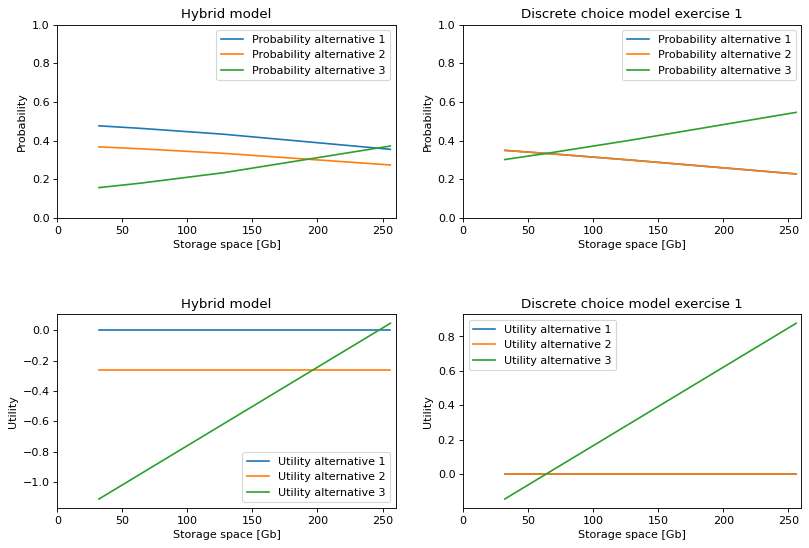

In [22]:
# Step 3: Plot the effect of the STORAGE of alternative 3 on the choice probabilities
# Plot the outputs
fig=plt.figure(figsize=(12,8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(221)
x_levels = np.array([32, 64, 128, 256])
plt.plot(x_levels,probs_x_sim[:,0], label = "Probability alternative 1")
plt.plot(x_levels,probs_x_sim[:,1], label = "Probability alternative 2")
plt.plot(x_levels,probs_x_sim[:,2], label = "Probability alternative 3")
plt.legend(loc = "best")
plt.title('Hybrid model')
plt.xlabel("Storage space [Gb]")
plt.ylabel("Probability")
plt.xlim([0, 260])
plt.ylim([0, 1])

plt.subplot(223)
utility_ANN_X_sim_V1 = 0 # As utilities are not absolute, we can arbitrarily fix V1 to zero
utility_ANN_X_sim_V2 = np.log(probs_x_sim[:,1]/probs_x_sim[:,0]) # Utility of alternative 2 relative to V1
utility_ANN_X_sim_V3 = np.log(probs_x_sim[:,2]/probs_x_sim[:,0]) # Utility of alternative 3 relative to V1
plt.plot(x_levels,np.tile(utility_ANN_X_sim_V1,(len(x_levels))), label = "Utility alternative 1")
plt.plot(x_levels,utility_ANN_X_sim_V2,                          label = "Utility alternative 2")
plt.plot(x_levels,utility_ANN_X_sim_V3,                          label = "Utility alternative 3")
plt.legend(loc = "best")
plt.title('Hybrid model')
plt.xlabel("Storage space [Gb]")
plt.ylabel("Utility")
plt.xlim([0,260])

# For comparison we also add the plots for the DCM
betas_DCM = {"B_camera": 0.812309,"B_cost":-0.010879,"B_size":2.106680,"B_storage":0.004567} # These are the beta estimates of exercise 1

# Compute utility using the estimated betas
V1_X_sim = betas_DCM['B_cost']*X_sim[:,0] + betas_DCM['B_size']*X_sim[:,1] + betas_DCM['B_storage']*X_sim[:,2] + betas_DCM['B_camera']*X_sim[:,3]
V2_X_sim = betas_DCM['B_cost']*X_sim[:,4] + betas_DCM['B_size']*X_sim[:,5] + betas_DCM['B_storage']*X_sim[:,6] + betas_DCM['B_camera']*X_sim[:,7]
V3_X_sim = betas_DCM['B_cost']*X_sim[:,8] + betas_DCM['B_size']*X_sim[:,9] + betas_DCM['B_storage']*X_sim[:,10] + betas_DCM['B_camera']*X_sim[:,11]

# Compute probabilities
P1_sim = np.exp(V1_X_sim) / (np.exp(V1_X_sim)+np.exp(V2_X_sim)+np.exp(V3_X_sim))
P2_sim = np.exp(V2_X_sim) / (np.exp(V1_X_sim)+np.exp(V2_X_sim)+np.exp(V3_X_sim))
P3_sim = np.exp(V3_X_sim) / (np.exp(V1_X_sim)+np.exp(V2_X_sim)+np.exp(V3_X_sim))
P_sim = np.transpose([P1_sim, P2_sim, P3_sim])

plt.subplot(222)
x_levels = np.array([32, 64, 128, 256])
plt.plot(x_levels,P_sim[:,0], label= "Probability alternative 1")
plt.plot(x_levels,P_sim[:,1], label= "Probability alternative 2")
plt.plot(x_levels,P_sim[:,2], label= "Probability alternative 3")
plt.title('Discrete choice model exercise 1')
plt.legend(loc = "best")
plt.xlabel("Storage space [Gb]")
plt.ylabel("Probability")
plt.xlim([0,260])
plt.ylim([0, 1])

plt.subplot(224)
x_levels = np.array([32, 64, 128, 256])
plt.plot(x_levels,V1_X_sim-V1_X_sim, label= "Utility alternative 1")
plt.plot(x_levels,V2_X_sim-V1_X_sim, label= "Utility alternative 2")
plt.plot(x_levels,V3_X_sim-V1_X_sim, label= "Utility alternative 3")
plt.title('Discrete choice model exercise 1')
plt.legend(loc = "best")
plt.xlabel("Storage space [Gb]")
plt.ylabel("Utility")
plt.xlim([0,260])

# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(hspace = 0.5)

### QUESTION 1. Compare these plots with those found in exercise 2 (lecture 1). What catches the eye? 

<font color='red'>

**ANSWER** <br>

...

### QUESTION 2. Compare the model performance, the estimates, and no. weights between this hybrid model, and those of the DCM and ANN of lecture 1. Explain why these results are in line with expectations


<font color='red'>

**ANSWER** <br>

...